In [4]:
import pandas as pd

stkstats=pd.read_csv('/content/ff5_model_south_korean.csv')
stkstats

,Unnamed: 0,HML,SMB,RMW,CMA,Mrt-Rf,RF
0,Sep-06,0.006425,0.024321,-0.008711,0.016506,0.016351,0.000592
1,Oct-06,0.036378,-0.013282,0.024852,0.013272,-0.009289,0.002299
2,Nov-06,0.073978,0.027534,0.053048,0.009446,0.047880,0.002613
3,Dec-06,0.048690,-0.040579,0.036586,-0.000362,0.012965,0.002275
4,Jan-07,0.021145,0.002354,-0.001954,-0.013445,-0.054119,0.002545
...,...,...,...,...,...,...,...
183,Dec-21,0.019923,0.025428,-0.011041,0.007339,0.065032,0.000675
184,Jan-22,0.071953,-0.009580,0.027120,0.021261,-0.114399,0.000043
185,Feb-22,0.034600,0.008061,0.008619,0.026437,0.012241,0.000715
186,Mar-22,0.009650,0.021068,-0.036388,-0.009552,0.030760,0.000435


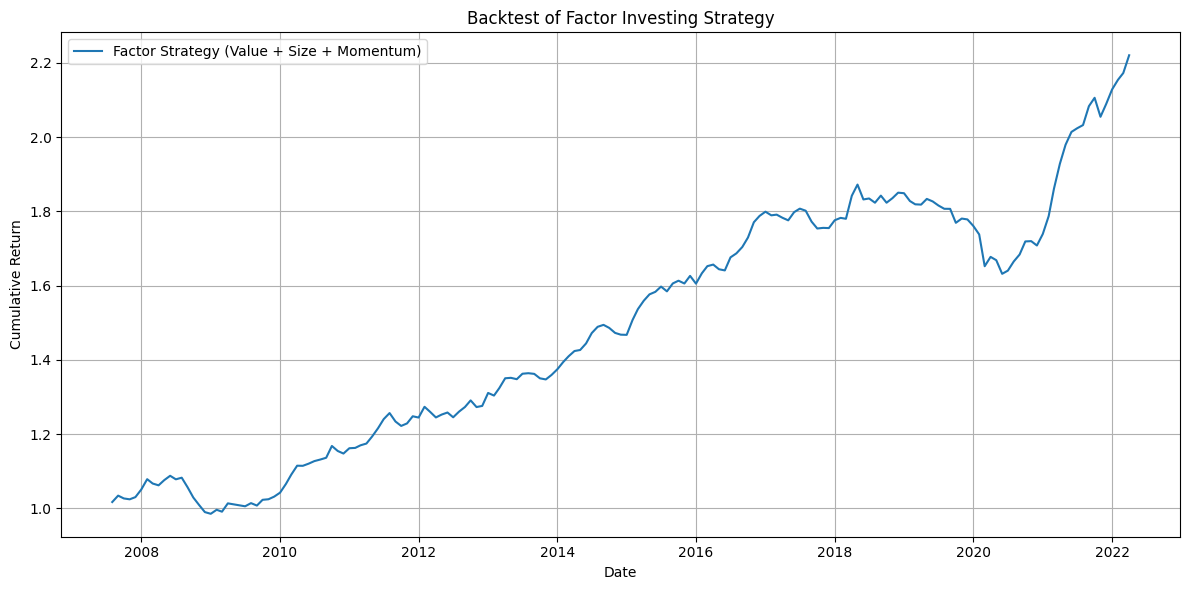

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Fama-French factor data
ff_factors = pd.read_csv('ff5_model_south_korean.csv')

# Convert and set the date column
ff_factors['Date'] = pd.to_datetime(ff_factors['Unnamed: 0'], format='%b-%y')
ff_factors.set_index('Date', inplace=True)
ff_factors = ff_factors.drop(columns=['Unnamed: 0'])

# Create a momentum proxy: 12-month rolling mean of market excess return (Mrt-Rf)
ff_factors['Momentum'] = ff_factors['Mrt-Rf'].rolling(window=12).mean()

# Drop initial NaNs from rolling calculation
ff_factors = ff_factors.dropna()

# Create strategy return: equal-weighted average of HML, SMB, and Momentum
ff_factors['Strategy_Return'] = (ff_factors['HML'] + ff_factors['SMB'] + ff_factors['Momentum']) / 3

# Compute cumulative return
ff_factors['Cumulative_Return'] = (1 + ff_factors['Strategy_Return']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(ff_factors.index, ff_factors['Cumulative_Return'], label='Factor Strategy (Value + Size + Momentum)')
plt.title('Backtest of Factor Investing Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Optimal Weights (HML, SMB, Momentum): [0.33692855 0.03764756 0.6254239 ]


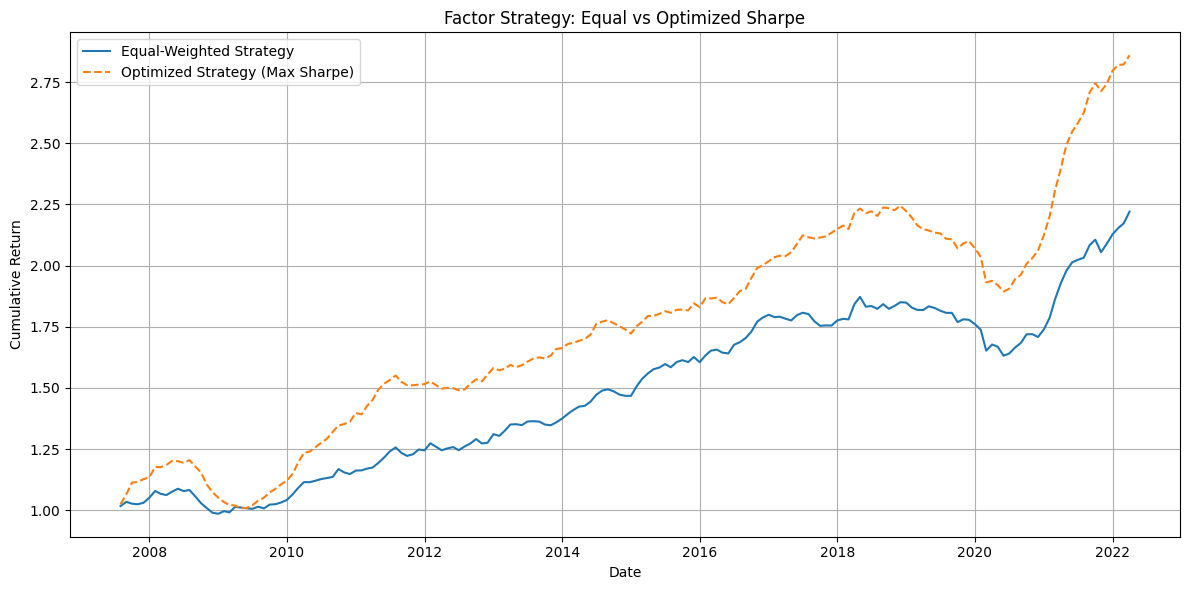

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load your data
ff_factors = pd.read_csv("ff5_model_south_korean.csv")
ff_factors['Date'] = pd.to_datetime(ff_factors['Unnamed: 0'], format='%b-%y')
ff_factors.set_index('Date', inplace=True)
ff_factors.drop(columns=['Unnamed: 0'], inplace=True)

# Create momentum proxy (12-month average of market excess return)
ff_factors['Momentum'] = ff_factors['Mrt-Rf'].rolling(window=12).mean()
ff_factors.dropna(inplace=True)

# Prepare factor returns and risk-free rate
factors = ff_factors[['HML', 'SMB', 'Momentum']]
risk_free = ff_factors['RF']

# Define the negative Sharpe ratio to minimize
def negative_sharpe(weights, returns, risk_free):
    portfolio_return = returns.dot(weights)
    excess_return = portfolio_return - risk_free
    sharpe = excess_return.mean() / excess_return.std()
    return -sharpe

# Optimization setup
initial_weights = np.array([1/3, 1/3, 1/3])
bounds = [(0, 1)] * 3
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Run optimization
opt_result = minimize(negative_sharpe, initial_weights, args=(factors, risk_free),
                      bounds=bounds, constraints=constraints)

# Get optimal weights
optimal_weights = opt_result.x
print("Optimal Weights (HML, SMB, Momentum):", optimal_weights)

# Calculate optimized returns
ff_factors['Optimized_Return'] = factors.dot(optimal_weights)
ff_factors['Optimized_Cumulative'] = (1 + ff_factors['Optimized_Return']).cumprod()

# Plot the result
plt.figure(figsize=(12, 6))
plt.plot(ff_factors.index, (1 + ((factors.sum(axis=1)) / 3)).cumprod(), label='Equal-Weighted Strategy')
plt.plot(ff_factors.index, ff_factors['Optimized_Cumulative'], label='Optimized Strategy (Max Sharpe)', linestyle='--')
plt.title('Factor Strategy: Equal vs Optimized Sharpe')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Columns in dataset: ['Unnamed: 0', 'HML', 'SMB', 'RMW', 'CMA', 'Mrt-Rf', 'RF']
                            OLS Regression Results                            
Dep. Variable:       Excess_Portfolio   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.205e+29
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        05:17:59   Log-Likelihood:                 7390.0
No. Observations:                 188   AIC:                        -1.477e+04
Df Residuals:                     182   BIC:                        -1.475e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

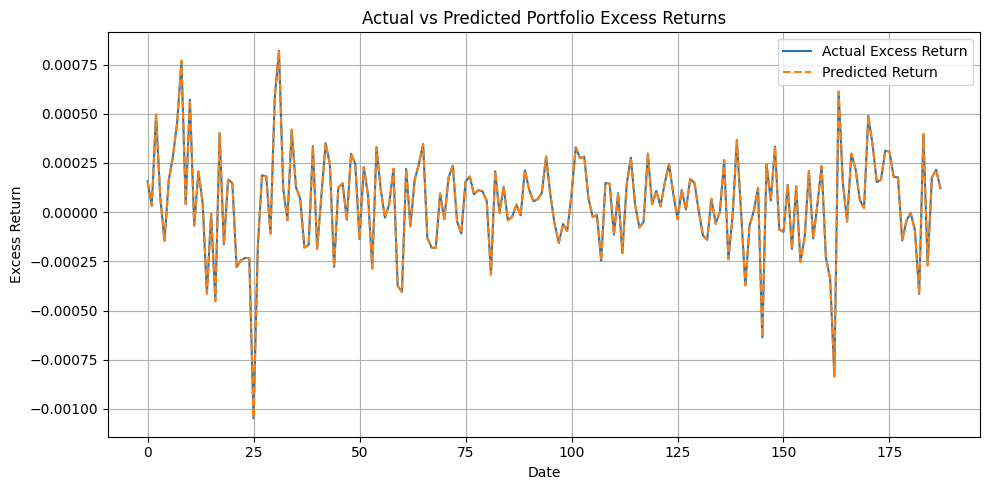

In [3]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load Fama-French factor data
ff = pd.read_csv("ff5_model_south_korean.csv")

# Inspect column names
print("Columns in dataset:", ff.columns.tolist())

# Rename the first column to 'Date' if it contains the time info
# Assuming the first column is 'Unnamed: 0' or similar
if 'Unnamed: 0' in ff.columns:
    ff.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Scale numeric values (assuming they're in percent)
factor_cols = ['Mrt-Rf', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
ff[factor_cols] = ff[factor_cols] / 100

# --- Sample Portfolio Return (replace with real data if available)
# For demonstration, simulate a portfolio with Market + Value tilt
ff['Portfolio'] = 0.4 * ff['Mrt-Rf'] + 0.3 * ff['HML'] + 0.3 * ff['SMB'] + ff['RF']

# Compute Excess Return
ff['Excess_Portfolio'] = ff['Portfolio'] - ff['RF']

# --- Run Regression: Excess Return ~ Mkt-RF + SMB + HML + RMW + CMA
X = ff[['Mrt-Rf', 'SMB', 'HML', 'RMW', 'CMA']]
y = ff['Excess_Portfolio']

# Add intercept
X = sm.add_constant(X)

# OLS Regression
model = sm.OLS(y, X).fit()

# Output summary
print(model.summary())

# --- Plot actual vs predicted returns
ff['Predicted'] = model.predict(X)
plt.figure(figsize=(10, 5))
plt.plot(ff.index, ff['Excess_Portfolio'], label='Actual Excess Return')
plt.plot(ff.index, ff['Predicted'], label='Predicted Return', linestyle='--')
plt.title('Actual vs Predicted Portfolio Excess Returns')
plt.xlabel('Date')
plt.ylabel('Excess Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
